In [2]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Compared to prey_predator.ipynb, we added hierarchy (increase R from 1 to 3). Users specify among which `est_param_names` becomes `hier_est_param_names`. Hierarchy in at least one parameter automatically adds subscripts to evey integrated outputs (integrated structure including, but not limited to `target_simulated_vector`).

In [3]:
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 3, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ("prey_birth_frac", "pred_birth_frac"),
    "hier_est_param_names" : ("pred_birth_frac"),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.01
}

prior = {
    ("prey_birth_frac", "normal", 0.8, 0.08, 0),
    ("pred_birth_frac", "normal", 0.05, 0.005, 0),
    ("m_noise_scale", "normal", .01, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

In [5]:
modelname = "prey_predator_S1N200Q2R3"
draws2data = az.from_netcdf(f"data/{modelname}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{modelname}/data2draws.nc")

## diagnose numerically with InferenceData
Change before and after adding hierarchy can be seen from `Dimensions`, as hierarchical estimated parameter `pred_birth_frac` and  `prey`, `predator`, `porcess_noise` now have three dimension (=R from precision above).

In [6]:
draws2data

Inference data with groups:
	> prior
	> prior_predictive
	> sample_stats_prior

Same with data2draws. Differences are also shown in index of `Data variables`. e.g. result of estimation for `prey_birth_frac` is (chain, draw) whereas `pred_birth_frac` has (chain, draw, pred_birth_frac_dim_0). Although `process_noise` is included, noise_scale is set to 0 during `data2draws()`, so we can ignore.


In [7]:
data2draws

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [8]:
az.summary(data2draws)

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_noise_scale,0.570,0.233,0.338,0.802,0.155,0.127,3.0,2.0,2.23
prey_birth_frac,2.889,2.807,0.096,5.682,1.862,1.536,3.0,71.0,2.23
pred_birth_frac[0],2.159,2.108,0.062,4.257,1.398,1.154,3.0,46.0,2.23
pred_birth_frac[1],0.235,0.169,0.066,0.403,0.112,0.093,3.0,57.0,2.22
pred_birth_frac[2],2.678,2.635,0.055,5.300,1.748,1.442,3.0,71.0,2.24
...,...,...,...,...,...,...,...,...,...
"process_noise[24.76, 1]",-0.003,0.000,-0.003,-0.003,0.000,0.000,21.0,72.0,2.32
"process_noise[24.76, 2]",-0.003,0.000,-0.003,-0.003,0.000,0.000,11.0,79.0,2.23
"process_noise[24.885, 0]",-0.003,0.000,-0.003,-0.003,0.000,0.000,200.0,68.0,2.30
"process_noise[24.885, 1]",-0.003,0.000,-0.003,-0.003,0.000,0.000,22.0,72.0,2.31


## Diagnose visually with time series, trace, pair, rank plots
### time series of target simulated and its measurement noise added observed vector (TODO: plot this by region)

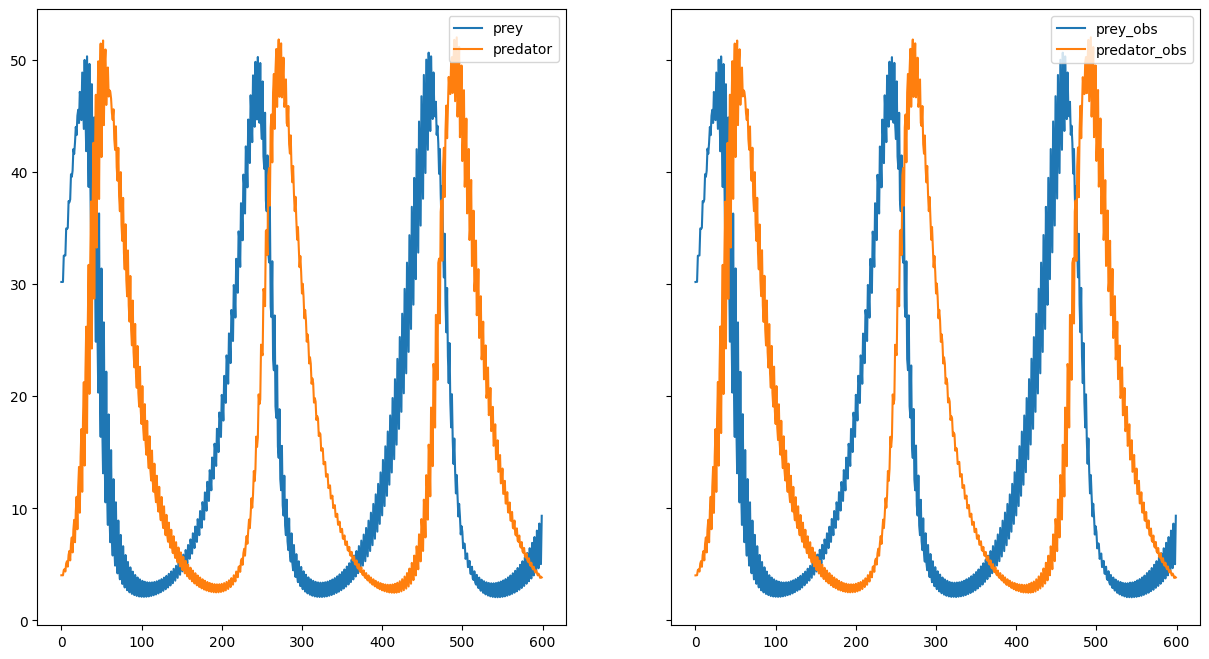

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'pred_birth_frac'}>,
        <AxesSubplot: title={'center': 'pred_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'prey_birth_frac'}>,
        <AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

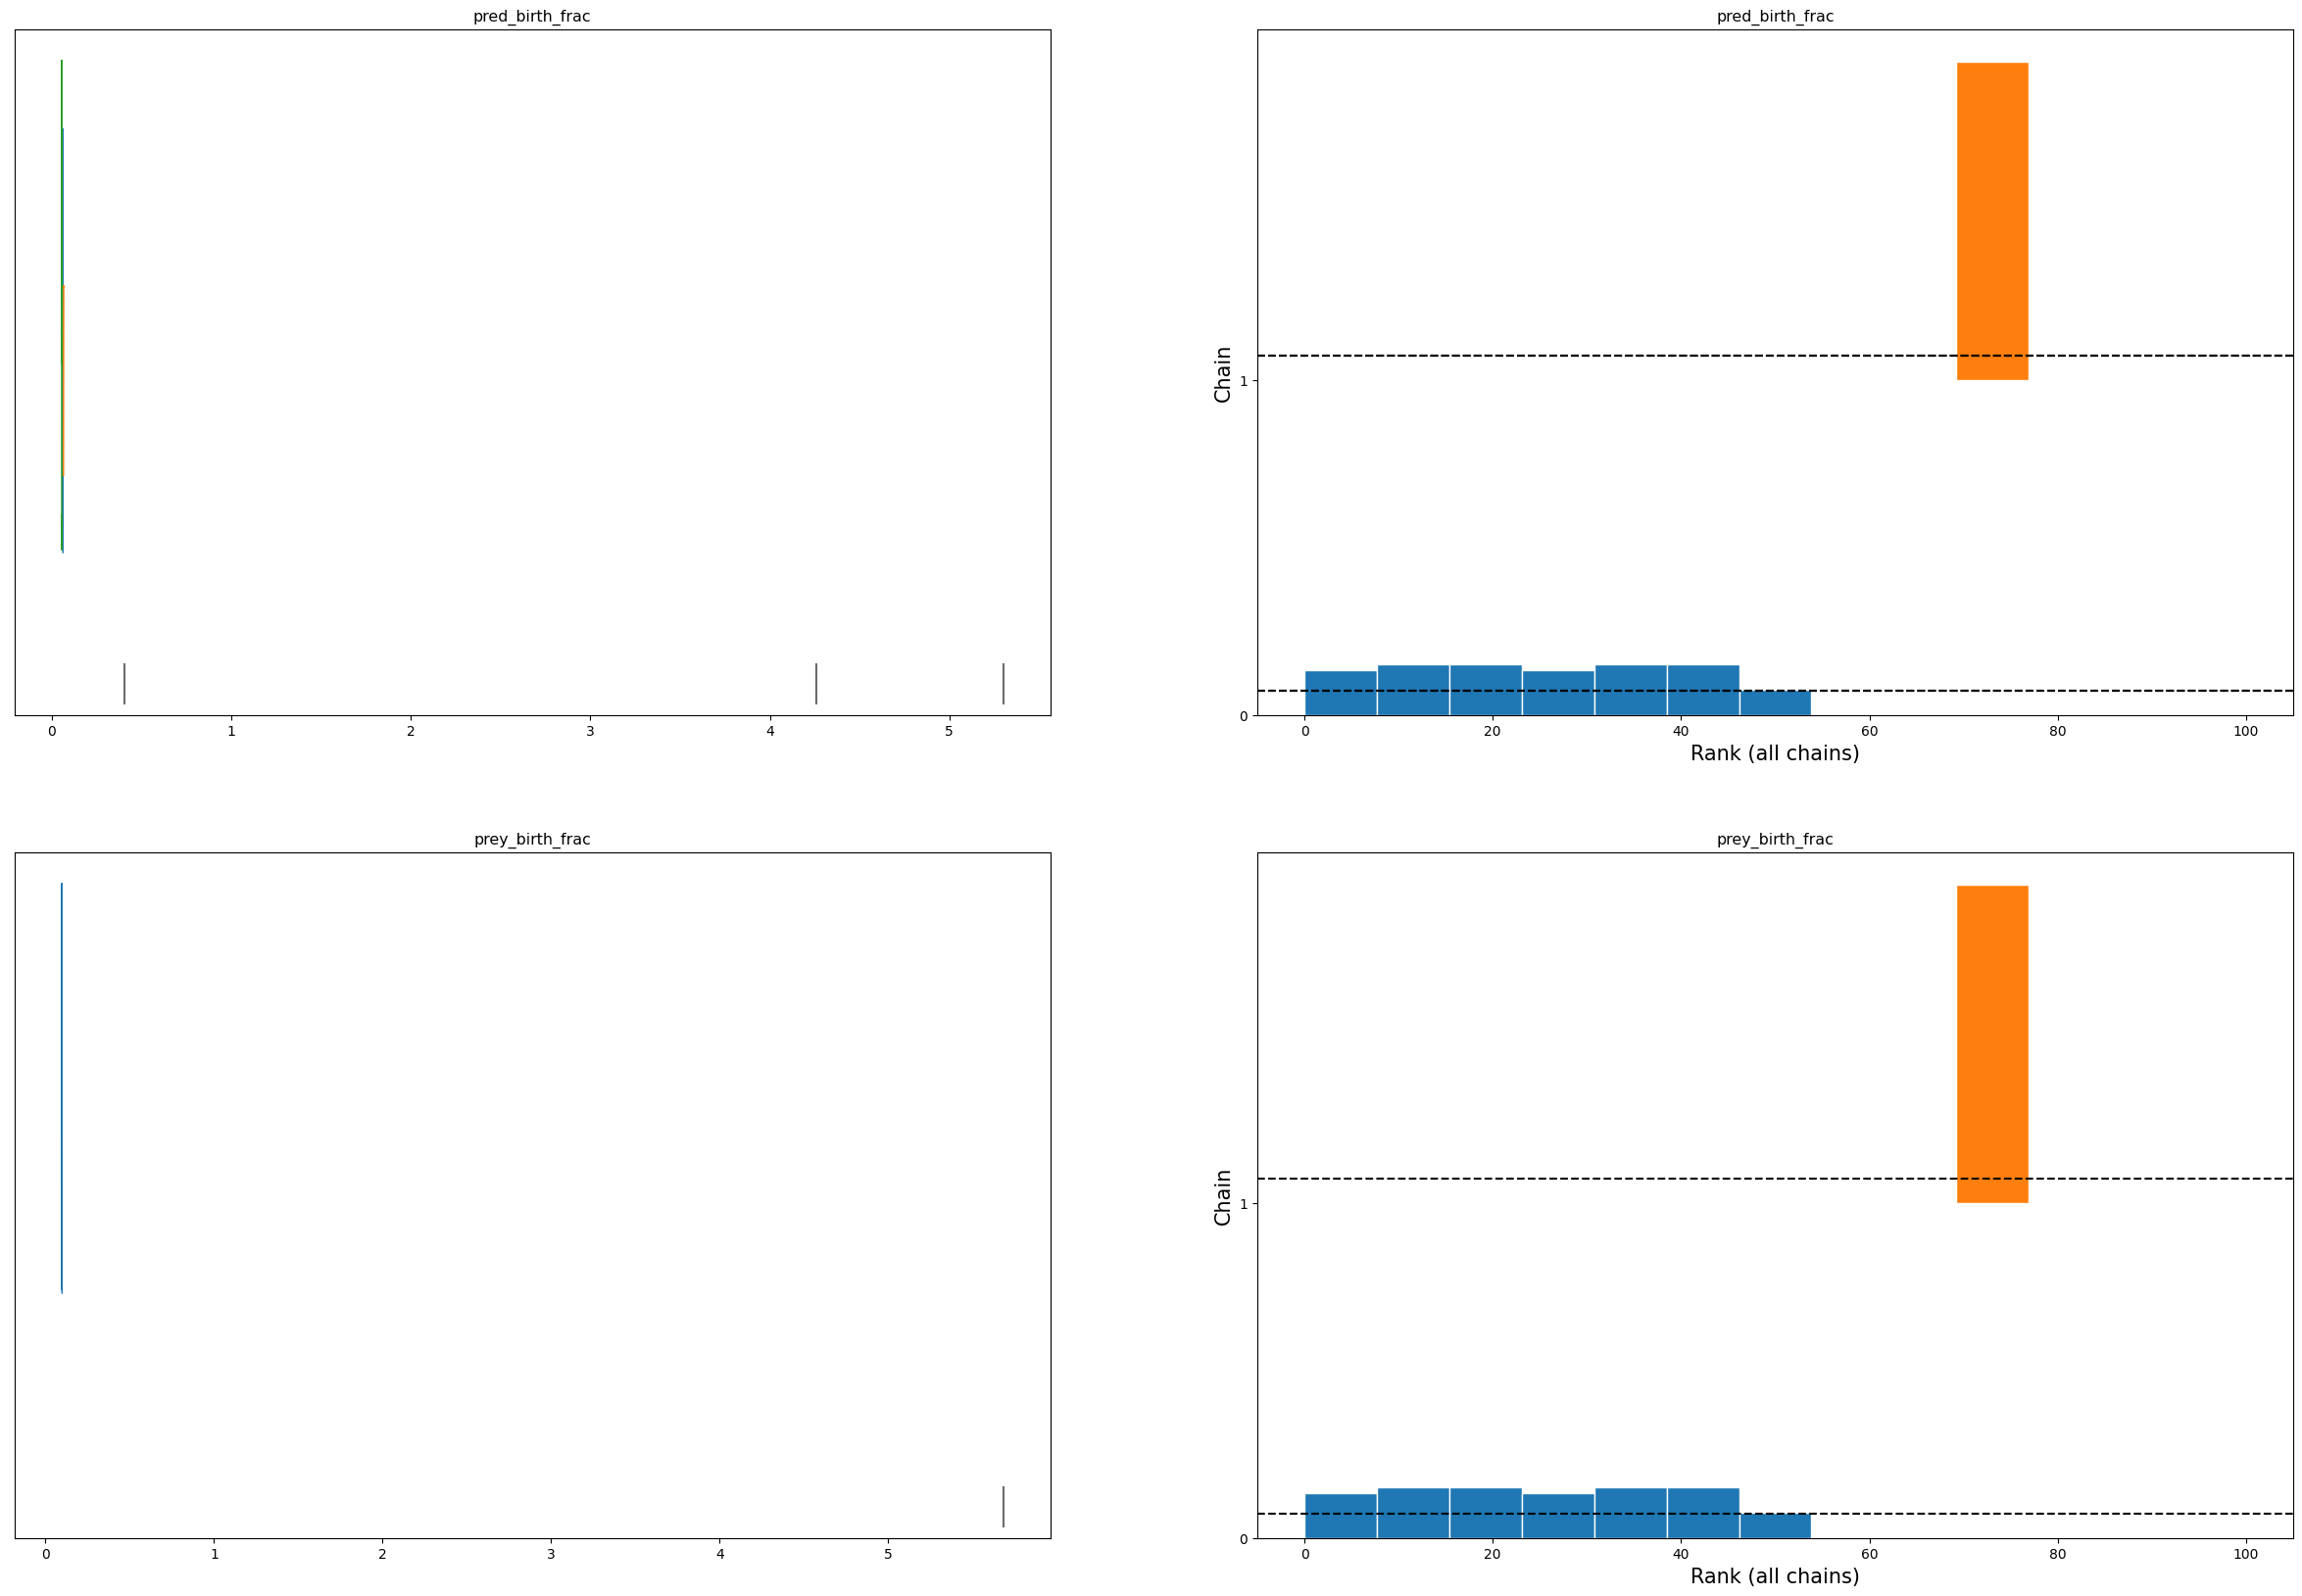

In [14]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars")

### pair plot focused and all

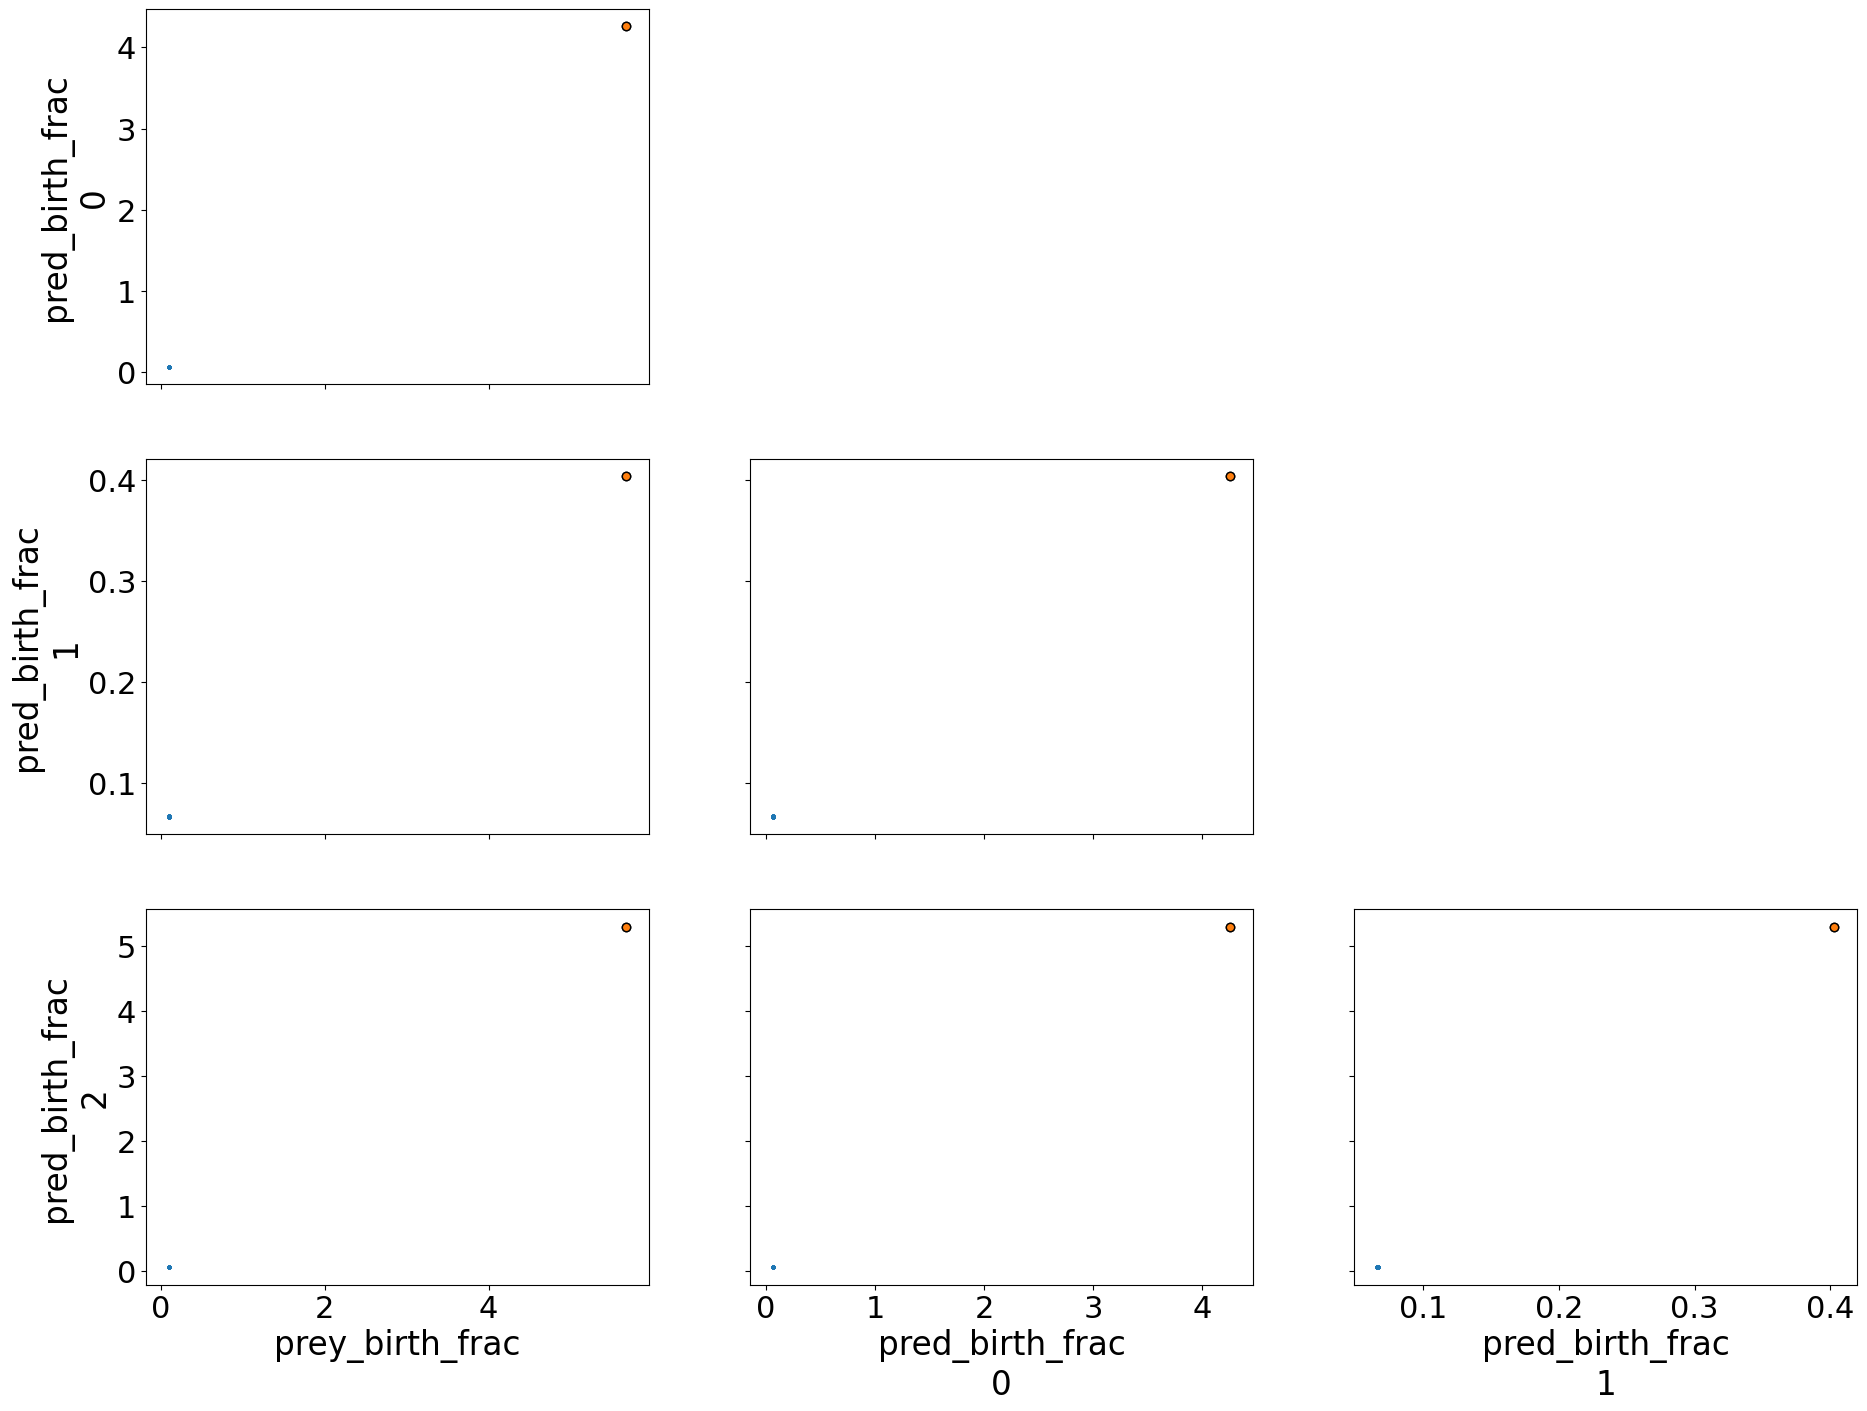

In [15]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

/Users/hyunjimoon/Dropbox/stanify/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


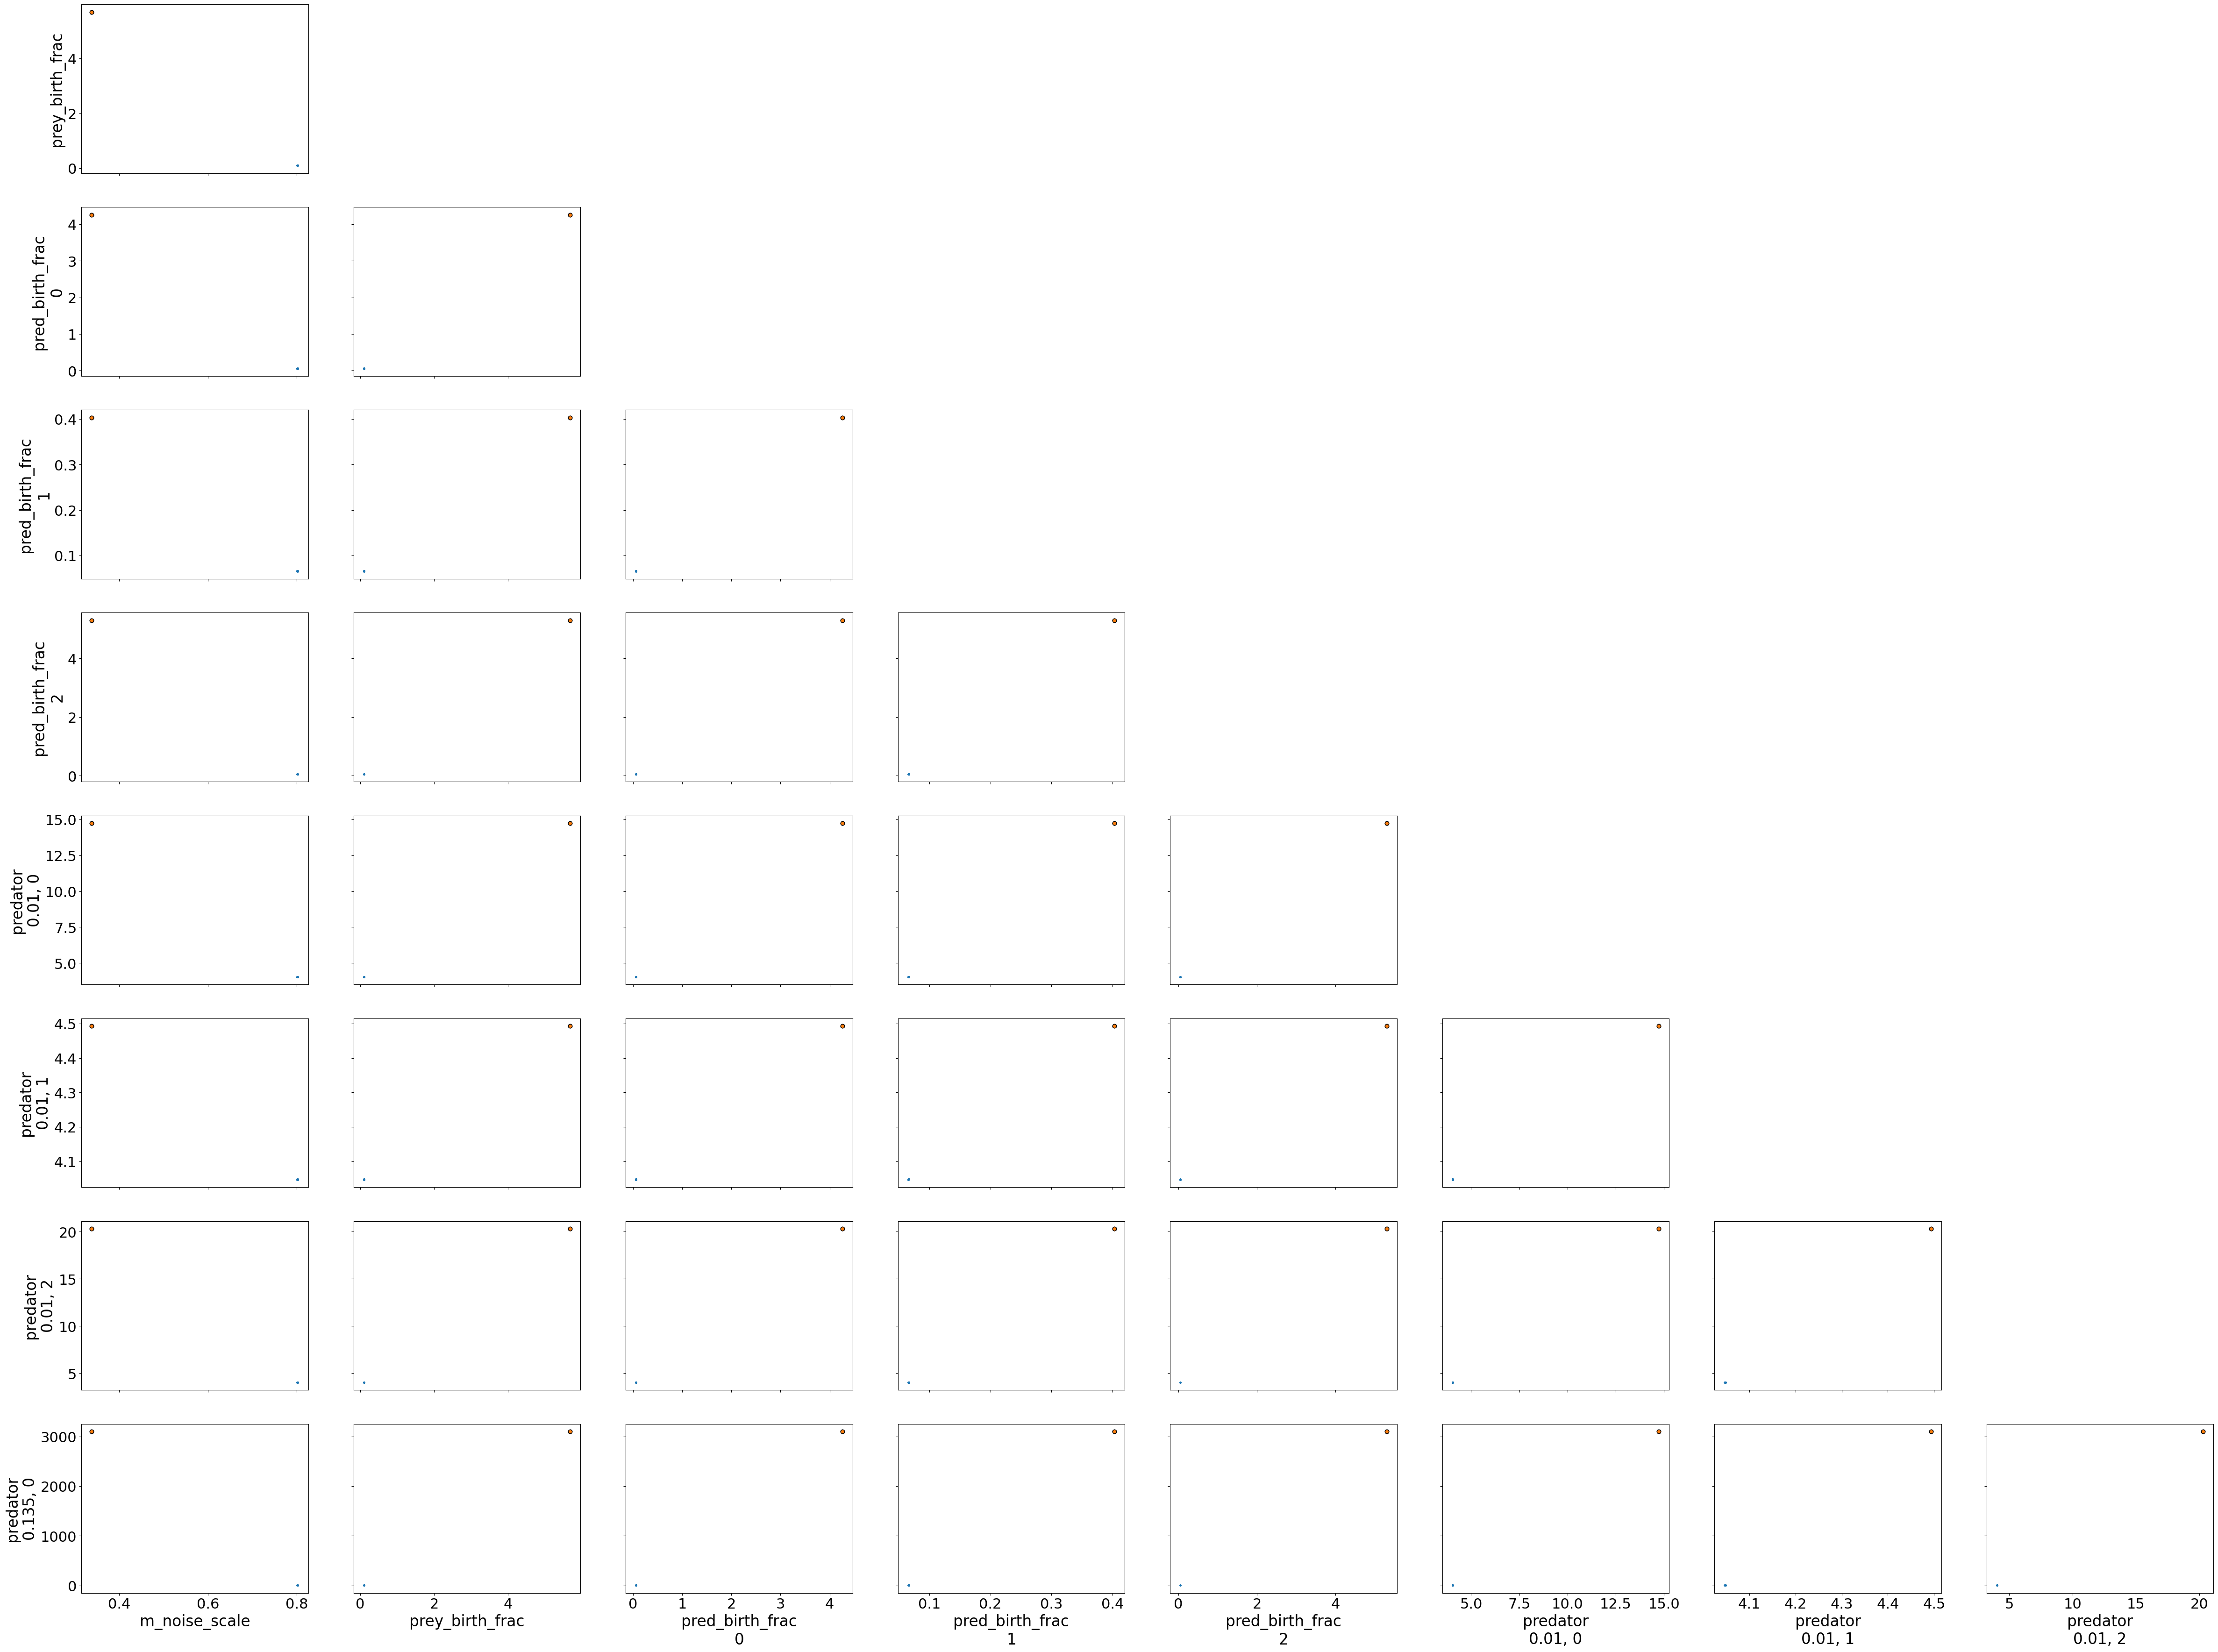

In [16]:
ax = az.plot_pair(data2draws,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

### rank plot
indicates more than one peak

array([<AxesSubplot: title={'center': 'prey_birth_frac'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot: title={'center': 'pred_birth_frac\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

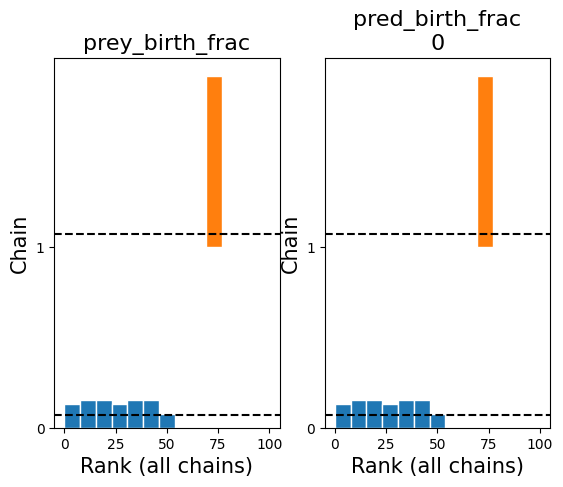

In [17]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [18]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())

functions{
  #include functions.stan
}

data{
    int <lower=0> S;  // # of draws from prior 
    int <lower=0> M;  // # of draws from posterior (# of chains * # of draws from each chain)
    int <lower=0> N;  // # of observation
    int <lower=0> Q;  // # of target_simulated_stock and obs_vectors 
    int <lower=0> R;  // # of subgroups for hierarchical Bayes 
    real <lower=0> time_step;
    array[N] real integration_times;
    vector[200] process_noise_uniform_driving;
    real process_noise_scale;
}

transformed data {
    real initial_time = 0.0;

    // Initial ODE values
    real predator__init = 4;
    real prey__init = 30;
    real process_noise__init = 0;

    // Initialize ODE stock vector
    vector[3] initial_outcome; 
    initial_outcome[1] = predator__init;
    initial_outcome[2] = prey__init;
    initial_outcome[3] = process_noise__init;
}

generated quantities{
    real m_noise_scale = normal_rng(0.01, 0.001);
    real prey_birth_frac = normal_rng(0.8, 0.08);
    real